# Model features exploration on different datasets

3 different datasets are used to explore the features of the model. The datasets are extracted from FBref. \
The features are :
- elo_score
- true_skill
- glick2
- avg_goals

The datasets are:
- Matches_euro 226 matches 
- Matches_big5 ~80 000 matches from the top 5 leagues europe
- Matches_Fifa  to come

## Env setup

In [59]:
import os

import pandas as pd
import numpy as np
from dotenv import load_dotenv

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores


In [61]:
load_dotenv()
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

DB_TN_MATCHES_EURO = os.getenv('DB_TN_MATCHES_EURO')
DB_TN_MATCHES = os.getenv('DB_TN_MATCHES')
DB_TN_MATCHES_BIG5 = os.getenv('DB_TN_MATCHES_BIG5')
DB_TN_MATCHES_WC = os.getenv('DB_TN_MATCHES_WC')
DB_TN_MATCHES_FBREF = os.getenv('DB_TN_MATCHES_FBREF')

## 1. Matches_euro (fbref)

In [3]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_MATCHES_EURO}")
    matches_euro = pd.read_sql(query, connection)

In [4]:
matches_euro

,game_id,league,season,game,round,week,day,date,time,home_team,...,attendance,venue,referee,match_report,notes,index,away_g,home_g,away_sat,home_sat
0,d0cc54df,INT-European Championships,0001,2000-06-10 Belgium-Sweden,Group stage,1.0,Sat,2000-06-10,20:45:00,Belgium,...,46700.0,Stade Roi Baudouin,Markus Merk,/en/matches/d0cc54df/Belgium-Sweden-June-10-20...,None,4640472,1.0,2.0,NaN,NaN
1,acf38877,INT-European Championships,0001,2000-06-11 France-Denmark,Group stage,1.0,Sun,2000-06-11,18:00:00,France,...,28100.0,Jan Breydelstadion,Günter Benkö,/en/matches/acf38877/France-Denmark-June-11-20...,None,15909458,0.0,3.0,NaN,NaN
2,4b680532,INT-European Championships,0001,2000-06-11 Netherlands-Czechia,Group stage,1.0,Sun,2000-06-11,20:45:00,Netherlands,...,50800.0,Johan Cruyff ArenA,Pierluigi Collina,/en/matches/4b680532/Netherlands-Czechia-June-...,None,13857731,0.0,1.0,NaN,NaN
3,6027ced9,INT-European Championships,0001,2000-06-11 Türkiye-Italy,Group stage,1.0,Sun,2000-06-11,14:30:00,Türkiye,...,22500.0,GelreDome,Hugh Dallas,/en/matches/6027ced9/Turkiye-Italy-June-11-200...,None,2727014,2.0,1.0,NaN,NaN
4,afcab359,INT-European Championships,0001,2000-06-12 Germany-Romania,Group stage,1.0,Mon,2000-06-12,18:00:00,Germany,...,28500.0,Stade Maurice Dufrasne,Kim Milton Nielsen,/en/matches/afcab359/Germany-Romania-June-12-2...,None,11856579,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,None,INT-European Championships,2425,2024-06-25 Netherlands-Austria,Group stage,3.0,Tue,2024-06-25,18:00:00,Netherlands,...,NaN,Olympiastadion Berlin,None,None,None,12042657,NaN,NaN,NaN,NaN
258,None,INT-European Championships,2425,2024-06-26 Czechia-Türkiye,Group stage,3.0,Wed,2024-06-26,21:00:00,Czechia,...,NaN,Volksparkstadion,None,None,None,2598241,NaN,NaN,NaN,NaN
259,None,INT-European Championships,2425,2024-06-26 Georgia-Portugal,Group stage,3.0,Wed,2024-06-26,21:00:00,Georgia,...,NaN,Veltins-Arena,None,None,None,10115670,NaN,NaN,NaN,NaN
260,None,INT-European Championships,2425,2024-06-26 Slovakia-Romania,Group stage,3.0,Wed,2024-06-26,18:00:00,Slovakia,...,NaN,Deutsche Bank Park,None,None,None,10264785,NaN,NaN,NaN,NaN


In [5]:
matches_euro_finished = matches_euro[matches_euro['score'].notnull()]
matches_euro_finished

,game_id,league,season,game,round,week,day,date,time,home_team,...,attendance,venue,referee,match_report,notes,index,away_g,home_g,away_sat,home_sat
0,d0cc54df,INT-European Championships,0001,2000-06-10 Belgium-Sweden,Group stage,1.0,Sat,2000-06-10,20:45:00,Belgium,...,46700.0,Stade Roi Baudouin,Markus Merk,/en/matches/d0cc54df/Belgium-Sweden-June-10-20...,None,4640472,1.0,2.0,NaN,NaN
1,acf38877,INT-European Championships,0001,2000-06-11 France-Denmark,Group stage,1.0,Sun,2000-06-11,18:00:00,France,...,28100.0,Jan Breydelstadion,Günter Benkö,/en/matches/acf38877/France-Denmark-June-11-20...,None,15909458,0.0,3.0,NaN,NaN
2,4b680532,INT-European Championships,0001,2000-06-11 Netherlands-Czechia,Group stage,1.0,Sun,2000-06-11,20:45:00,Netherlands,...,50800.0,Johan Cruyff ArenA,Pierluigi Collina,/en/matches/4b680532/Netherlands-Czechia-June-...,None,13857731,0.0,1.0,NaN,NaN
3,6027ced9,INT-European Championships,0001,2000-06-11 Türkiye-Italy,Group stage,1.0,Sun,2000-06-11,14:30:00,Türkiye,...,22500.0,GelreDome,Hugh Dallas,/en/matches/6027ced9/Turkiye-Italy-June-11-200...,None,2727014,2.0,1.0,NaN,NaN
4,afcab359,INT-European Championships,0001,2000-06-12 Germany-Romania,Group stage,1.0,Mon,2000-06-12,18:00:00,Germany,...,28500.0,Stade Maurice Dufrasne,Kim Milton Nielsen,/en/matches/afcab359/Germany-Romania-June-12-2...,None,11856579,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,1a1e61fe,INT-European Championships,2021,2021-07-03 Czechia-Denmark,Quarter-finals,NaN,Sat,2021-07-03,20:00:00,Czechia,...,16306.0,Bakı Olimpiya Stadionu,Björn Kuipers,/en/matches/1a1e61fe/Czechia-Denmark-July-3-20...,None,5187292,2.0,1.0,NaN,NaN
225,8589d5c5,INT-European Championships,2021,2021-07-03 Ukraine-England,Quarter-finals,NaN,Sat,2021-07-03,21:00:00,Ukraine,...,11880.0,Stadio Olimpico,Felix Brych,/en/matches/8589d5c5/Ukraine-England-July-3-20...,None,1347908,4.0,0.0,NaN,NaN
226,997fefb3,INT-European Championships,2021,2021-07-06 Italy-Spain,Semi-finals,NaN,Tue,2021-07-06,20:00:00,Italy,...,57811.0,Wembley Stadium,Felix Brych,/en/matches/997fefb3/Italy-Spain-July-6-2021-E...,Italy won on penalty kicks following extra time,2912206,1.0,1.0,2.0,4.0
227,3c9e014a,INT-European Championships,2021,2021-07-07 England-Denmark,Semi-finals,NaN,Wed,2021-07-07,20:00:00,England,...,64950.0,Wembley Stadium,Danny Makkelie,/en/matches/3c9e014a/England-Denmark-July-7-20...,Required Extra Time,10712042,1.0,2.0,NaN,NaN


In [6]:
matches_euro_finished['FTR'] = matches_euro_finished.apply(lambda x: 1 if x['home_g'] > x['away_g'] else 0 if x['home_g'] == x['away_g'] else -1, axis=1)

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_5532\729747416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_euro_finished['FTR'] = matches_euro_finished.apply(lambda x: 1 if x['home_g'] > x['away_g'] else 0 if x['home_g'] == x['away_g'] else -1, axis=1)


In [7]:
elo_scores(matches_euro_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
goal_stats(matches_euro_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
glicko2_scores(matches_euro_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
trueskill_scores(matches_euro_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')

c:\users\jdelavande\projects\optim-sportbet\src\feature_eng\team_stats\elo_scores.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[elo_home_before_col] = 0.
c:\users\jdelavande\projects\optim-sportbet\src\feature_eng\team_stats\elo_scores.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[elo_away_before_col] = 0.
c:\users\jdelavande\projects\optim-sportbet\src\feature_eng\team_stats\goal_stats.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [8]:
matchs = matches_euro_finished
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.300000
1,weighted_accuracy,0.537500
2,accuracy_home,0.500000
3,accuracy_draw,0.625000
4,accuracy_away,0.475000
5,recall_all,1.136667
6,weighted_recall,0.300000
7,balanced_accuracy,0.378889
8,recall_home,0.850000
9,recall_draw,0.100000


In [9]:
matchs = matches_euro_finished
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col = ['index']
Y_col = 'FTR'

train_test_split_fn = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1

metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.325000
1,weighted_accuracy,0.543750
2,accuracy_home,0.425000
3,accuracy_draw,0.750000
4,accuracy_away,0.475000
5,recall_all,0.996667
6,weighted_recall,0.325000
7,balanced_accuracy,0.332222
8,recall_home,0.650000
9,recall_draw,0.000000


## 2. Matches (soccer data uk)

In [10]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_MATCHES}")
    matches = pd.read_sql(query, connection)

matches

,date,home_team,away_team,FTHG,FTAG,FTR,HTHG,HTAG,HTR,referee,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,2018-08-10 12:00:00,Man United,Leicester,2,1,H,1,0,H,A Marriner,...,2.12,2.03,1.85,1.79,17.0,-0.75,1.75,1.70,2.29,2.21
1,2018-08-11 12:00:00,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,...,2.05,1.98,1.92,1.83,20.0,-0.75,2.20,2.13,1.80,1.75
2,2018-08-11 12:00:00,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,...,2.00,1.95,1.96,1.87,22.0,-0.25,2.18,2.11,1.81,1.77
3,2018-08-11 12:00:00,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,...,2.05,1.98,1.90,1.84,23.0,1.00,1.84,1.80,2.13,2.06
4,2018-08-11 12:00:00,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,...,2.10,2.01,1.88,1.81,20.0,0.25,2.20,2.12,1.80,1.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10775,2024-05-26 19:45:00,Empoli,Roma,2,1,H,1,1,D,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10776,2024-05-26 19:45:00,Frosinone,Udinese,0,1,A,0,0,D,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10777,2024-05-26 19:45:00,Lazio,Sassuolo,1,1,D,0,0,D,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10778,2024-05-26 17:00:00,Napoli,Lecce,0,0,D,0,0,D,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
matches[['away_team', 'FTHG', 'FTAG']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10780 entries, 0 to 10779
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   away_team  10780 non-null  object
 1   FTHG       10780 non-null  int64 
 2   FTAG       10780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 252.8+ KB


## 3. Matches_big5 (fbref)

In [14]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_MATCHES_BIG5}")
    big_5 = pd.read_sql(query, connection)

big_5_finished = big_5[big_5['score'].notnull()]
big_5_finished.sort_values('date', inplace=True)
big_5_finished.reset_index(drop=True, inplace=True)

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_5532\1628154004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_5_finished.sort_values('date', inplace=True)


In [15]:
big_5_finished['FTR'] = big_5_finished.apply(lambda x: 1 if x['home_g'] > x['away_g'] else 0 if x['home_g'] == x['away_g'] else -1, axis=1)
elo_scores(big_5_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
goal_stats(big_5_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
glicko2_scores(big_5_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')
trueskill_scores(big_5_finished, home_team_id_col='home_team', away_team_id_col='away_team', home_team_goal_col='home_g', away_team_goal_col='away_g')

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_5532\2329328619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_5_finished['FTR'] = big_5_finished.apply(lambda x: 1 if x['home_g'] > x['away_g'] else 0 if x['home_g'] == x['away_g'] else -1, axis=1)
c:\users\jdelavande\projects\optim-sportbet\src\feature_eng\team_stats\elo_scores.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[elo_home_before_col] = 0.
c:\users\jdelavande\projects\optim-sportbet\src\feature_eng\team_stats\elo_scores.py:38: Se

In [16]:
big_5_finished

,index,game_id,league,season,game,round,week,day,date,time,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
0,14068897,66c0a3b0,ENG-Premier League,2425,1924-08-30 West Brom-Notts County,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
1,15965219,c9302adf,ENG-Premier League,2425,1924-08-30 West Ham-Preston,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
2,12365152,5cfe793a,ENG-Premier League,2425,1924-08-30 Tottenham-Bolton,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
3,5831693,b82a3ea3,ENG-Premier League,2425,1924-08-30 Sheffield Utd-Blackburn,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
4,14930337,c4630ad0,ENG-Premier League,2425,1924-08-30 Nott'ham Forest-Arsenal,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85708,15813577,a2652733,ITA-Serie A,2324,2024-05-26 Atalanta-Torino,None,38.0,Sun,2024-05-26,18:00:00,...,1.861111,0.972973,1628.116305,1546.025761,27.742646,28.105439,0.058934,0.058928,25.728612,23.987220
85709,6781429,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,...,3.000000,1.200000,1462.406858,1466.161784,28.266911,28.545271,0.059718,0.059429,21.886997,21.947828
85710,15176133,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,...,0.000000,1.030303,1510.284946,1434.375425,28.843911,27.017348,0.059221,0.059371,22.277822,21.150588
85711,1580127,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,...,1.029412,2.000000,1432.689358,1512.152792,27.360642,28.792405,0.059370,0.059220,21.072675,22.349451


In [48]:
matchs = big_5_finished
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

X_col = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']
X_col = ['trueskill_home_before',
       'trueskill_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match']
Y_col = 'FTR'

pipeline.fit(matchs[X_col], matchs[Y_col])
result = pipeline.predict(matches_euro_finished[X_col])
result_df = pd.DataFrame({'FTR': matches_euro_finished['FTR'], 'FTR_pred': result})
ac = accuracy_fn(result_df, 'FTR', 'FTR_pred')
ac


(0.4424778761061947,
 0.6180593625185997,
 (0.5752212389380531, 0.6991150442477876, 0.6106194690265486))

In [53]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier())
])

X_col = ['elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before']
X_col = ['trueskill_home_before',
       'trueskill_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match']
metrics_mean, metrics, _ = train_test(matchs, pipeline, X_col, Y_col, train_test_split_fn, result_df_all_splits, m, beta)
pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})

,metrics,values
0,accuracy,0.464078
1,weighted_accuracy,0.624454
2,accuracy_home,0.556978
3,accuracy_draw,0.663532
4,accuracy_away,0.707646
5,recall_all,1.179514
6,weighted_recall,0.464078
7,balanced_accuracy,0.393171
8,recall_home,0.739130
9,recall_draw,0.157522


In [18]:
big_5_finished.columns

Index(['index', 'game_id', 'league', 'season', 'game', 'round', 'week', 'day',
       'date', 'time', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'away_g',
       'home_g', 'away_sat', 'home_sat', 'FTR', 'elo_home_before',
       'elo_away_before', 'home_team_goals_season_to_date_before_match',
       'away_team_goals_season_to_date_before_match',
       'home_team_number_of_match_played', 'away_team_number_of_match_played',
       'avg_home_team_goals_season_to_date_before_match',
       'avg_away_team_goals_season_to_date_before_match',
       'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
       'glicko2_rd_away_before', 'glicko2_vol_home_before',
       'glicko2_vol_away_before', 'trueskill_home_before',
       'trueskill_away_before'],
      dtype='object')

In [19]:
big_5_finished['home_team'].unique()

array(['West Brom', 'West Ham', 'Tottenham', 'Sheffield Utd',
       "Nott'ham Forest", 'Liverpool', 'Newcastle Utd', 'Bury', 'Burnley',
       'Birmingham', 'Leeds United', 'Blackburn', 'Notts County',
       'Cardiff City', 'Arsenal', 'Aston Villa', 'Bolton', 'Huddersfield',
       'Sunderland', 'Everton', 'Manchester City', 'Preston',
       'Grimsby Town', 'Sheffield Weds', 'Manchester Utd',
       'Leicester City', 'Blackpool', 'Derby County', 'Middlesbrough',
       'Chelsea', 'Portsmouth', 'Wolves', 'Stoke City', 'Brentford',
       'Charlton Ath', 'Birmingham City', 'Fulham', 'Luton Town',
       'Ipswich Town', 'Leyton Orient', 'Northampton', 'Southampton',
       'Coventry City', 'QPR', 'Crystal Palace', 'Norwich City',
       'Carlisle United', 'Bristol City', 'Brighton', 'Swansea City',
       'Watford', 'Oxford United', 'Wimbledon', 'Mannheim', 'Dortmund',
       'Köln', 'Hannover 96', 'Gladbach', 'Bayern Munich',
       "S'gart Kickers", 'Werder Bremen', 'St Pauli', 'Stut

In [20]:
big_5_finished[(big_5_finished['home_team'] == 'Manchester City') | (big_5_finished['away_team'] == 'Manchester City')]

,index,game_id,league,season,game,round,week,day,date,time,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
7,15921462,5f803c50,ENG-Premier League,2425,1924-08-30 Bury-Manchester City,None,1.0,Sat,1924-08-30,None,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
14,11856463,bbccf907,ENG-Premier League,2425,1924-09-01 Arsenal-Manchester City,None,2.0,Mon,1924-09-01,None,...,2.000000,2.000000,1506.329462,1506.329462,57.330401,57.330401,0.060000,0.060000,7.881405,7.881405
28,7937206,71e6a646,ENG-Premier League,2425,1924-09-06 Manchester City-Nott'ham Forest,None,3.0,Sat,1924-09-06,None,...,1.000000,0.000000,1499.766160,1487.344989,48.143156,48.133338,0.060000,0.060000,6.999474,-0.799872
43,7292713,b9bf49db,ENG-Premier League,2425,1924-09-13 Liverpool-Manchester City,None,3.0,Sat,1924-09-13,None,...,1.000000,2.000000,1487.423465,1504.775284,48.192745,42.720113,0.059999,0.060000,-0.516486,10.315087
55,5365792,db2a7d4f,ENG-Premier League,2425,1924-09-17 Manchester City-Arsenal,None,5.0,Wed,1924-09-17,None,...,2.250000,1.750000,1500.204276,1517.521752,39.128943,39.124501,0.060000,0.059996,8.092281,17.881737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85516,5062841,80bbb25e,ENG-Premier League,2324,2024-04-28 Nott'ham Forest-Manchester City,None,35.0,Sun,2024-04-28,16:30:00,...,1.235294,2.424242,1491.514896,1758.131132,28.464454,25.698196,0.058687,0.057661,22.625197,29.193962
85544,1422670,5a9032bf,ENG-Premier League,2324,2024-05-04 Manchester City-Wolves,None,36.0,Sat,2024-05-04,17:30:00,...,2.411765,1.371429,1758.793425,1503.414132,25.460501,28.442983,0.057660,0.058481,29.221309,23.527480
85582,10846116,4e211d29,ENG-Premier League,2324,2024-05-11 Fulham-Manchester City,None,37.0,Sat,2024-05-11,12:30:00,...,1.416667,2.485714,1478.818634,1759.486018,28.177670,25.360161,0.059028,0.057658,23.000718,29.256232
85625,3579864,2ba17e6d,ENG-Premier League,2324,2024-05-14 Tottenham-Manchester City,None,34.0,Tue,2024-05-14,20:00:00,...,1.972222,2.527778,1629.681657,1760.088823,27.806538,25.113866,0.057669,0.057657,25.824705,29.286526


<Axes: >

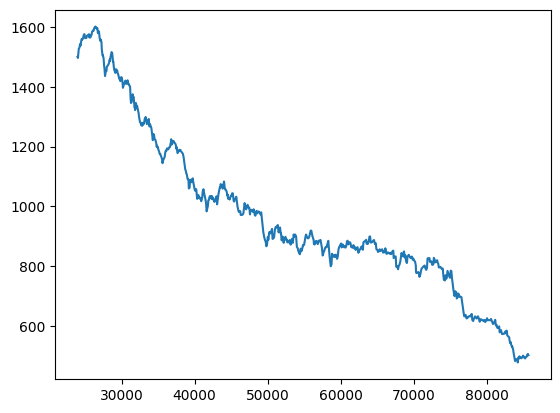

In [21]:

big_5_finished[(big_5_finished['home_team'] == 'Real Madrid')]['elo_home_before'].plot()

<Axes: >

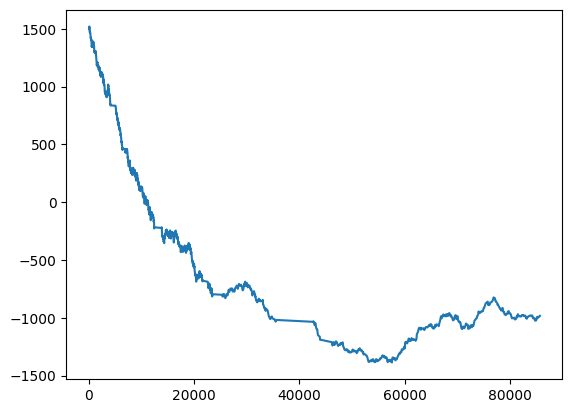

In [22]:
big_5_finished[(big_5_finished['home_team'] == 'Manchester City')]['elo_home_before'].plot()

<Axes: >

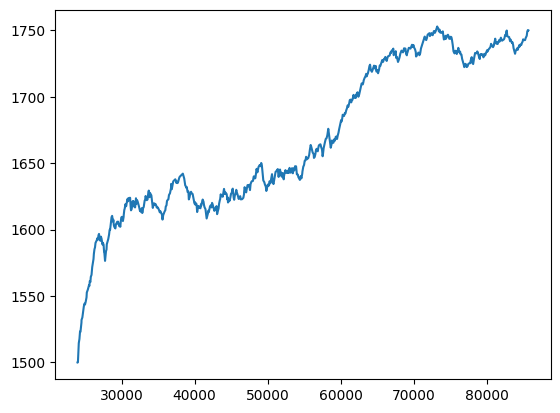

In [23]:
big_5_finished[(big_5_finished['home_team'] == 'Real Madrid')]['glicko2_home_before'].plot()

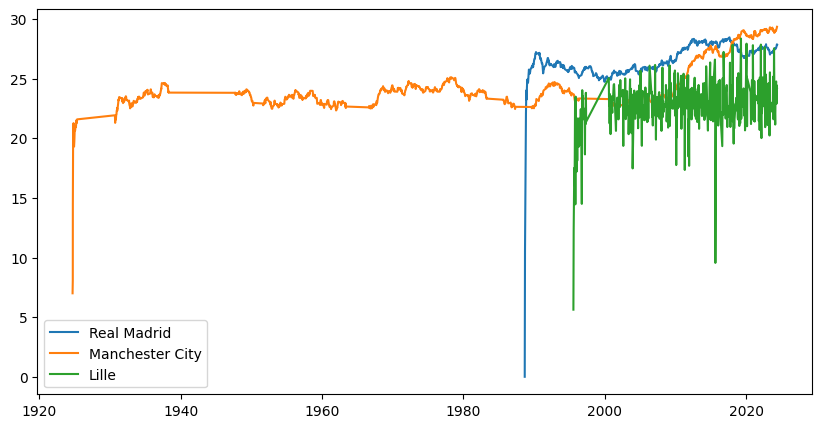

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Real Madrid')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Real Madrid')]['trueskill_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Manchester City')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Manchester City')]['trueskill_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Lille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Lille')]['trueskill_away_before'])
ax.legend(['Real Madrid', 'Manchester City', 'Lille'])
plt.show()

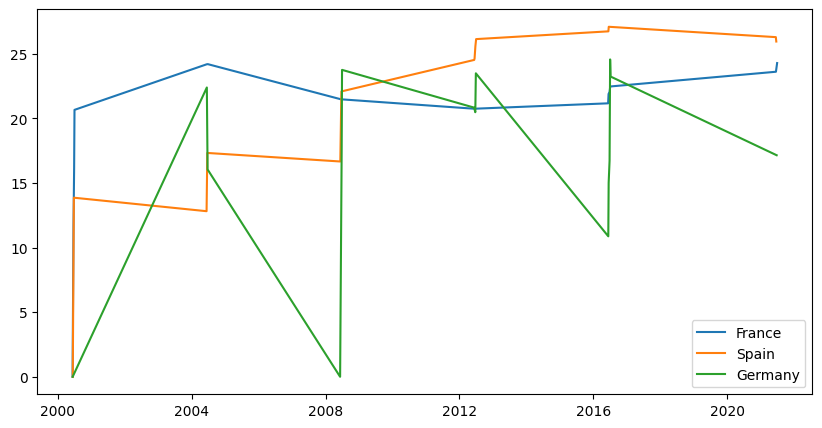

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(matches_euro_finished[(matches_euro_finished['home_team'] == 'France')]['date'], matches_euro_finished[(matches_euro_finished['home_team'] == 'France')]['trueskill_home_before'])
ax.plot(matches_euro_finished[(matches_euro_finished['home_team'] == 'Spain')]['date'], matches_euro_finished[(matches_euro_finished['home_team'] == 'Spain')]['trueskill_home_before'])
ax.plot(matches_euro_finished[(matches_euro_finished['home_team'] == 'Germany')]['date'], matches_euro_finished[(matches_euro_finished['home_team'] == 'Germany')]['trueskill_away_before'])
ax.legend(['France', 'Spain', 'Germany'])
plt.show()

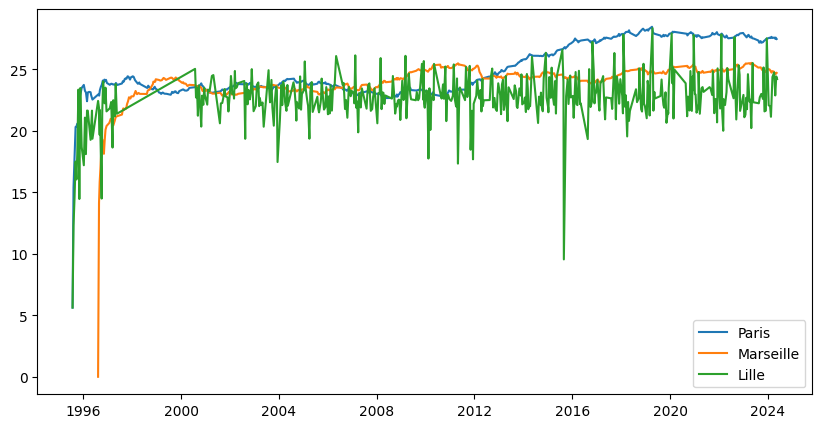

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['trueskill_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['trueskill_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Lille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Lille')]['trueskill_away_before'])
ax.legend(['Paris', 'Marseille', 'Lille'])
plt.show()

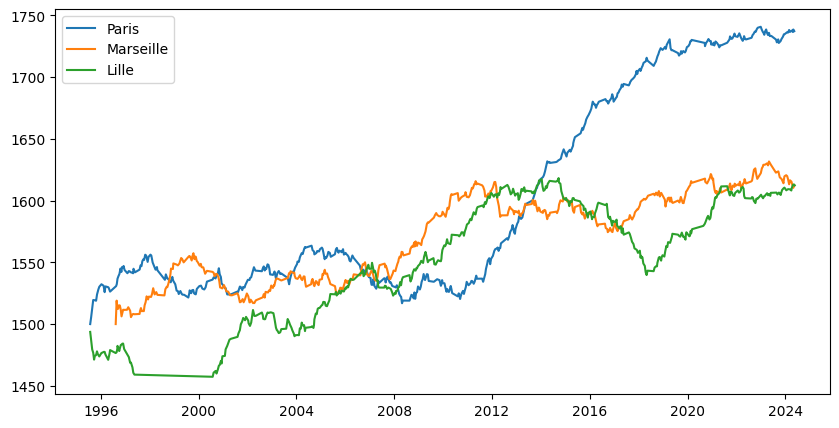

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['glicko2_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['glicko2_home_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Lille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Lille')]['glicko2_home_before'])
ax.legend(['Paris', 'Marseille', 'Lille'])
plt.show()

In [32]:
big_5_finished[big_5_finished["league"] == "FRA-Ligue 1"]["home_team"].unique()

array(['Bastia', 'Nantes', 'Montpellier', 'Monaco', 'Lens', 'Guingamp',
       'Saint-Étienne', 'Gueugnon', 'Cannes', 'Bordeaux', 'Nice', 'Metz',
       'Lille', 'Auxerre', 'Martigues', 'Paris S-G', 'Rennes',
       'Strasbourg', 'Lyon', 'Le Havre', 'Marseille', 'Caen', 'Nancy',
       'Toulouse', 'Châteauroux', 'Lorient', 'Sochaux', 'Troyes', 'Sedan',
       'Ajaccio', 'Le Mans', 'Istres', 'Valenciennes', 'Grenoble',
       'Boulogne', 'Brest', 'Arles-Avignon', 'Evian', 'Dijon', 'Reims',
       'Angers', 'Gazélec Ajaccio', 'Amiens', 'Nîmes', 'Clermont Foot'],
      dtype=object)

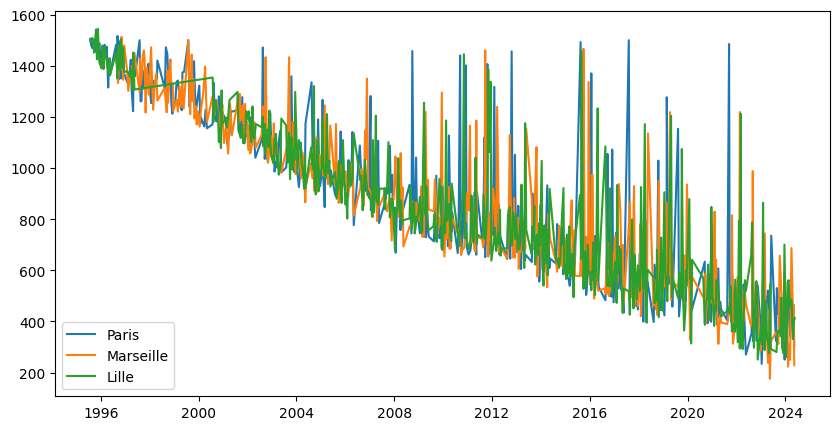

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Paris S-G')]['elo_away_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Marseille')]['elo_away_before'])
ax.plot(big_5_finished[(big_5_finished['home_team'] == 'Lille')]['date'], big_5_finished[(big_5_finished['home_team'] == 'Lille')]['elo_away_before'])
ax.legend(['Paris', 'Marseille', 'Lille'])
plt.show()

## 4. Matches_wc (fbref)

In [56]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_MATCHES_WC}")
    matches_wc = pd.read_sql(query, connection)

matches_wc_finished = matches_wc[matches_wc['score'].notnull()]
matches_wc_finished.sort_values('date', inplace=True)
matches_wc_finished.reset_index(drop=True, inplace=True)

In [57]:
matches_wc_finished

,index,game_id,league,season,game,round,week,day,date,time,...,away_team,attendance,venue,referee,match_report,notes,away_g,home_g,away_sat,home_sat
0,11912705,f24db046,INT-World Cup,3031,1930-07-13 France-Mexico,Group stage,NaN,Sun,1930-07-13,15:00:00,...,Mexico,4444,Pocitos (Neutral Site),Domingo Lombardi,/en/matches/f24db046/France-Mexico-July-13-193...,None,1,4,NaN,NaN
1,9378227,c54abca0,INT-World Cup,3031,1930-07-13 United States-Belgium,Group stage,NaN,Sun,1930-07-13,15:00:00,...,Belgium,18346,Parque Central (Neutral Site),Jose Macias,/en/matches/c54abca0/United-States-Belgium-Jul...,None,0,3,NaN,NaN
2,12284374,e64fb03a,INT-World Cup,3031,1930-07-14 Romania-Peru,Group stage,NaN,Mon,1930-07-14,14:50:00,...,Peru,2549,Pocitos (Neutral Site),Alberto Warnken,/en/matches/e64fb03a/Romania-Peru-July-14-1930...,None,1,3,NaN,NaN
3,6246885,470a07ef,INT-World Cup,3031,1930-07-14 Yugoslavia-Brazil,Group stage,NaN,Mon,1930-07-14,12:45:00,...,Brazil,24059,Parque Central (Neutral Site),Anibal Tejada,/en/matches/470a07ef/Yugoslavia-Brazil-July-14...,None,1,2,NaN,NaN
4,955260,17095a70,INT-World Cup,3031,1930-07-15 Argentina-France,Group stage,NaN,Tue,1930-07-15,16:00:00,...,France,23409,Parque Central (Neutral Site),Gilberto Rego,/en/matches/17095a70/Argentina-France-July-15-...,None,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,15914371,170c8725,INT-World Cup,2223,2022-12-10 Morocco-Portugal,Quarter-finals,NaN,Sat,2022-12-10,18:00:00,...,Portugal,44198,Al Thumama Stadium (Neutral Site),Facundo Tello,/en/matches/170c8725/Morocco-Portugal-December...,None,0,1,NaN,NaN
960,16391448,0b527037,INT-World Cup,2223,2022-12-13 Argentina-Croatia,Semi-finals,NaN,Tue,2022-12-13,22:00:00,...,Croatia,88966,Lusail Iconic Stadium (Neutral Site),Daniele Orsato,/en/matches/0b527037/Argentina-Croatia-Decembe...,None,0,3,NaN,NaN
961,8369388,85c72a0a,INT-World Cup,2223,2022-12-14 France-Morocco,Semi-finals,NaN,Wed,2022-12-14,22:00:00,...,Morocco,68294,Al Bayt Stadium (Neutral Site),César Arturo Ramos,/en/matches/85c72a0a/France-Morocco-December-1...,None,0,2,NaN,NaN
962,1350585,9d73d381,INT-World Cup,2223,2022-12-17 Croatia-Morocco,Third-place match,NaN,Sat,2022-12-17,18:00:00,...,Morocco,44137,Khalifa International Stadium (Neutral Site),Abdulrahman Ibrahim Al Jassim,/en/matches/9d73d381/Croatia-Morocco-December-...,None,1,2,NaN,NaN


## 5. Matches_fbref (fbref)

In [62]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_MATCHES_FBREF}")
    matches_fbref = pd.read_sql(query, connection)

matches_fbref_finished = matches_fbref[matches_fbref['score'].notnull()]
matches_fbref_finished.sort_values('date', inplace=True)
matches_fbref_finished.reset_index(drop=True, inplace=True)
matches_fbref_finished

C:\Users\jdelavande\AppData\Local\Temp\ipykernel_5532\364342357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_fbref_finished.sort_values('date', inplace=True)


,game_id,league,season,game,round,week,day,date,time,home_team,...,attendance,venue,referee,match_report,notes,index,away_g,home_g,away_sat,home_sat
0,b82a3ea3,ENG-Premier League,2425,1924-08-30 Sheffield Utd-Blackburn,None,1.0,Sat,1924-08-30,None,Sheffield Utd,...,NaN,None,None,/en/matches/b82a3ea3/Sheffield-United-Blackbur...,None,5831693,3.0,2.0,NaN,NaN
1,c9302adf,ENG-Premier League,2425,1924-08-30 West Ham-Preston,None,1.0,Sat,1924-08-30,None,West Ham,...,NaN,None,None,/en/matches/c9302adf/West-Ham-United-Preston-N...,None,15965219,0.0,1.0,NaN,NaN
2,be6f0ecf,ENG-Premier League,2425,1924-08-30 Liverpool-Aston Villa,None,1.0,Sat,1924-08-30,None,Liverpool,...,NaN,None,None,/en/matches/be6f0ecf/Liverpool-Aston-Villa-Aug...,None,12263104,4.0,2.0,NaN,NaN
3,8b4a0b4c,ENG-Premier League,2425,1924-08-30 Leeds United-Sunderland,None,1.0,Sat,1924-08-30,None,Leeds United,...,NaN,None,None,/en/matches/8b4a0b4c/Leeds-United-Sunderland-A...,None,6932190,1.0,1.0,NaN,NaN
4,5f803c50,ENG-Premier League,2425,1924-08-30 Bury-Manchester City,None,1.0,Sat,1924-08-30,None,Bury,...,NaN,None,None,/en/matches/5f803c50/Bury-Manchester-City-Augu...,None,15921462,2.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86898,2ee9be16,ITA-Serie A,2324,2024-05-26 Empoli-Roma,None,38.0,Sun,2024-05-26,20:45:00,Empoli,...,15896.0,Stadio Carlo Castellani,Davide Massa,/en/matches/2ee9be16/Empoli-Roma-May-26-2024-S...,None,16313095,1.0,2.0,NaN,NaN
86899,723ffa45,GER-Bundesliga,2324,2024-05-27 Düsseldorf-Bochum,German 1/2 Relegation/Promotion Play-offs,NaN,Mon,2024-05-27,20:30:00,Düsseldorf,...,51500.0,Merkur Spielarena,None,/en/matches/723ffa45/Dusseldorf-Bochum-May-27-...,Leg 2 of 2; Bochum won; Bochum won on penalty ...,6781429,3.0,0.0,6.0,5.0
86900,febd4e01,FRA-Ligue 1,2324,2024-05-30 Saint-Étienne-Metz,French 1/2 Relegation/Promotion Play-off,NaN,Thu,2024-05-30,20:30:00,Saint-Étienne,...,NaN,Stade Geoffroy-Guichard,None,/en/matches/febd4e01/Saint-Etienne-Metz-May-30...,Leg 1 of 2,15176133,1.0,2.0,NaN,NaN
86901,7f01f697,FRA-Ligue 1,2324,2024-06-02 Metz-Saint-Étienne,French 1/2 Relegation/Promotion Play-off,NaN,Sun,2024-06-02,17:00:00,Metz,...,28500.0,Stade Saint-Symphorien,None,/en/matches/7f01f697/Metz-Saint-Etienne-June-2...,Leg 2 of 2; Saint-Étienne won; Required Extra ...,1580127,2.0,2.0,NaN,NaN


In [64]:
matches_fbref_finished['index'].unique().shape

(86900,)

In [65]:
matches_fbref_finished.columns

Index(['game_id', 'league', 'season', 'game', 'round', 'week', 'day', 'date',
       'time', 'home_team', 'home_xg', 'score', 'away_xg', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'index',
       'away_g', 'home_g', 'away_sat', 'home_sat'],
      dtype='object')

In [67]:
matches_fbref_finished.describe()

,week,home_xg,away_xg,attendance,index,away_g,home_g,away_sat,home_sat
count,86184.000000,12761.000000,12761.000000,25155.000000,8.690300e+04,86903.000000,86903.000000,51.000000,51.000000
mean,19.594751,1.494201,1.213024,31197.929835,8.402659e+06,1.136198,1.625053,3.313725,3.352941
std,11.255363,0.824380,0.741789,17223.077420,4.840399e+06,1.121694,1.349215,1.303690,1.308794
min,1.000000,0.000000,0.000000,13.000000,4.960000e+02,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.900000,0.700000,18366.000000,4.233263e+06,0.000000,1.000000,2.000000,3.000000
50%,19.000000,1.400000,1.100000,27733.000000,8.401790e+06,1.000000,1.000000,3.000000,3.000000
75%,29.000000,2.000000,1.600000,40491.500000,1.259625e+07,2.000000,2.000000,4.000000,4.000000
max,42.000000,7.000000,5.700000,230506.000000,1.677710e+07,9.000000,9.000000,6.000000,6.000000
